In [1]:
!pip install transformers

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU đang sử dụng: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Không tìm thấy GPU, đang chạy trên CPU.")


GPU đang sử dụng: Tesla T4


In [3]:
df = pd.read_csv("data.csv")

label_encoder = LabelEncoder()
df["MOOD_LABEL"] = label_encoder.fit_transform(df["MOOD"])
mood_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Ánh xạ giữa tên mood và số:")
print(mood_mapping)

Ánh xạ giữa tên mood và số:
{'Angry': 0, 'Chill': 1, 'Happy': 2, 'In love': 3, 'Neutral(Meh)': 4, 'Sad': 5}


In [4]:
X = df["COMMENT"]
y = df["MOOD_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Load pre-trained model and tokenizer
model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode_texts(texts):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=256, return_tensors="pt")
    return encodings

train_encodings = encode_texts(X_train)
test_encodings = encode_texts(X_test)

# train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=256)
# test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=256)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return {k: v.to(device) for k, v in item.items()}

# Tạo dataset
train_dataset = EmotionDataset(train_encodings, list(y_train))
test_dataset = EmotionDataset(test_encodings, list(y_test))



In [8]:
# Load mô hình PhoBERT với số lớp output tương ứng với số nhãn cảm xúc
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",             # Nơi lưu kết quả huấn luyện
    evaluation_strategy="epoch",        # Đánh giá mô hình sau mỗi epoch
    save_strategy="epoch",              # Lưu checkpoint sau mỗi epoch
    per_device_train_batch_size=16,      # Số mẫu/batch trong tập train
    per_device_eval_batch_size=16,       # Số mẫu/batch trong tập eval
    num_train_epochs=4,                 # Số epoch (lặp lại dữ liệu huấn luyện)
    weight_decay=0.01,                  # Hệ số regularization (tránh overfitting)
    dataloader_pin_memory=False,
    logging_dir="./logs",               # Nơi lưu logs
    seed=24
)

# Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Bắt đầu fine-tune mô hình
trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-559f2354cd70>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-559f2354cd70>:11: UserWarning: To copy construct from a tensor, it is recommende

Epoch,Training Loss,Validation Loss
1,No log,1.207010
2,No log,0.766464
3,No log,0.665136
4,No log,0.634723


<ipython-input-6-559f2354cd70>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-559f2354cd70>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
<ipython-input-6-559f2354cd70>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-559f2354cd70>:11: UserWarning: To copy construct from a tensor, it

TrainOutput(global_step=180, training_loss=0.9589661492241753, metrics={'train_runtime': 89.7412, 'train_samples_per_second': 32.092, 'train_steps_per_second': 2.006, 'total_flos': 34041215312640.0, 'train_loss': 0.9589661492241753, 'epoch': 4.0})

<ipython-input-6-559f2354cd70>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-559f2354cd70>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)


Accuracy: 0.7556
              precision    recall  f1-score   support

       Angry       0.84      0.91      0.87        34
       Chill       0.58      0.39      0.47        28
       Happy       0.85      0.72      0.78        32
     In love       0.46      0.64      0.53        25
Neutral(Meh)       0.91      0.94      0.93        33
         Sad       0.86      0.86      0.86        28

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.75       180



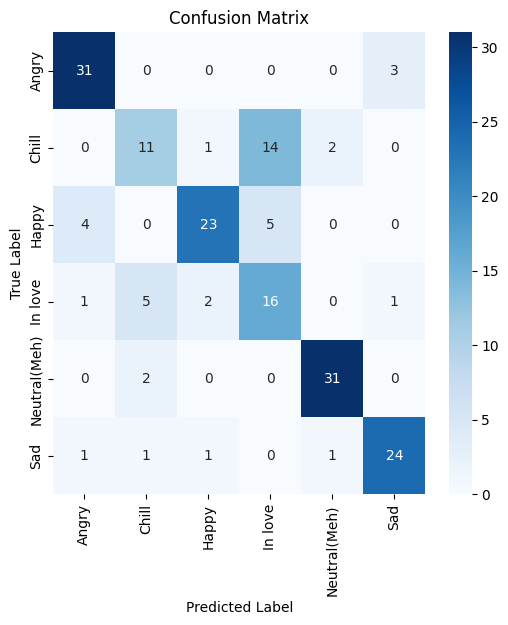

In [9]:
# Dự đoán trên tập test
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# Tính độ chính xác
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, preds, target_names=label_encoder.classes_))

# Vẽ Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# prompt: lưu lại mô hình và nạp lại mô hình  và dự đoán nhãn thông qua câu input nhập vào

# Lưu mô hình
model_path = "./saved_model"  # Đường dẫn lưu model
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

# Nạp lại mô hình
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


def predict_mood(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax().item()

    # Giả sử mood_mapping đã được định nghĩa trước đó
    for mood, label in mood_mapping.items():
      if label == predicted_class_id:
        predicted_mood = mood
        break
    return predicted_mood




In [86]:
# Ví dụ sử dụng:
input_text = input("Nhập câu văn: ")
predicted_label = predict_mood(input_text)
print(f"Dự đoán: {predicted_label}")

Nhập câu văn: tôi ghét loài người
Dự đoán: Sad


In [62]:
df[df["MOOD"]=="In love"].head(20)

,COMMENT,MOOD,MOOD_LABEL
600,"Gió nhẹ, nắng nhạt. Cảm giác thật… dễ chịu",In love,3
601,"Ngày hôm nay, chỉ cần nằm đây thôi cũng đủ rồi",In love,3
602,Tâm trạng phẳng lặng như mặt hồ chiều,In love,3
603,"Một tách trà nóng, một cuốn sách cũ. Hoàn hảo",In love,3
604,Thư thái đến lạ. Không suy nghĩ gì cả,In love,3
605,"Chỉ cần nghe tiếng mưa rơi, mọi phiền muộn ta...",In love,3
606,"Cảm giác an yên, như được thả trôi trên dòng ...",In love,3
607,Thở sâu… rồi lại thở sâu… Mọi thứ nhẹ nhàng quá,In love,3
608,"Thời gian trôi chậm, như đang ở một thế giới...",In love,3
609,"Thật sự thư giãn, không cần gì hơn thế nữa",In love,3
